In [1]:
# Copyright 2018 Esref Ozdemir
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classifier Testing
In this notebook, we test our Random Forest classifiers in two ways:
1. We show the cross validation results on the training data by using untrained classifier set to the optimal parameters found during model optimization phase.
2. Since cross-validation tends to be over-optimistic about classifier performance, we use our previously trained classifier to test a separate test data.

In [12]:
%matplotlib inline

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split
import itertools

from utils import plot_hbar_nameval, plot_confusion_matrix

In [13]:
def describe_dataset(dataset):
    print('Shape: {}\n'.format(dataset.shape))

    heading = 'Event counts'
    print(heading + '\n' + '-'*len(heading))
    for key, val in Counter(dataset.values[:, 0]).items():
        print('{}\t: {}'.format(int(key), val))

### Labels and Column Names

In [14]:
df = pd.read_csv('../data/train/all_train.csv')
classes = ['Null', 'Corner', 'Freekick', 'Goal', 'Penalty']
feature_names = list(df.columns[1:])

### Turkish Labels and Column Names

In [15]:
classes_tr = ['Boş küme', 'Korner', 'S. Vuruş', 'Gol', 'Penaltı']
feature_names_tr = ['Konuk ort. x', 'Konuk ort. y', 'Konuk konveks merkez x', 'Konuk konveks merkez y',
        'Konuk konveks en yakın', 'Konuk konveks en uzak',
        'Konuk konveks max sürat', 'Konuk konveks max x', 'Konuk konveks max y',
        'Konuk konveks min x', 'Konuk konveks min y', 'Konuk max yoğunluk',
        'Konuk içsel uzaklık', 'Konuk min yoğunluk',
        'Ev sahibi ort. x', 'Ev sahibi ort. y', 'Ev sahibi konveks merkez x', 'Ev sahibi konveks merkez y',
        'Ev sahibi konveks en yakın', 'Ev sahibi konveks en uzak',
        'Ev sahibi konveks max sürat', 'Ev sahibi konveks max x', 'Ev sahibi konveks max y',
        'Ev sahibi konveks min x', 'Ev sahibi konveks min y', 'Ev sahibi max yoğunluk',
        'Ev sahibi içsel uzaklık', 'Ev sahibi min yoğunluk',
        'Max katışıklık',
        'Bütün konveks merkez x', 'Bütün konveks merkez y',
        'Bütün konveks en yakın', 'Bütün konveks en uzak',
        'Bütün konveks max sürat', 'Bütün konveks max x', 'Bütün konveks max y',
        'Bütün konveks min x', 'Bütün konveks min y', 'Bütün max yoğunluk', 'Bütün min yoğunluk',
        'Max doğrusallık',
        'Hakem sürati', 'Hakem x', 'Hakem y'    
]

### Cross Validation Function

In [25]:
def random_forest_cv(clf, X, y, feature_names, classes=None, k=10):
    label_ids = sorted(np.unique(y), key=abs)
    
    # shuffle the data
    X, y = shuffle(X, y)
    
    # get K folds
    skf = KFold(n_splits=k, shuffle=True)
    skf.get_n_splits(X, y)
    
    # cumulative confusion matrix and feature importance arrays
    conf_mat = np.zeros((len(label_ids), len(label_ids)))
    feature_importances = np.zeros(X.shape[1])
    
    # for each fold in KFold
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # fit with current train set
        clf = clf.fit(X_train, y_train)
        # predict the current test set
        y_pred = clf.predict(X_test)
        
        # keep cumulative sum of conf_mat and feature_importances
        conf_mat += confusion_matrix(y_test, y_pred, labels=label_ids)
        feature_importances += clf.feature_importances_
     
    # normalize importances
    feature_importances /= k
    
    if classes is None:
        classes = label_ids
    
    # plot
    plot_confusion_matrix(conf_mat, classes, 'Prediction', 'Truth', normalize=True)
    plot_hbar_nameval(feature_names, feature_importances, 'Feature importances', max_bars=20)
    return conf_mat, feature_importances

## 10-Fold Cross Validation on Training Data
In this section, we test our model parameters using cross validation on training data. Classifier used in this section is not previously trained. Hence, it is not our final model.

In [17]:
train_data = pd.read_csv('../data/train/all_train.csv')
x_train = train_data.values[:, 1:]
y_train = train_data.values[:, 0]

In [18]:
describe_dataset(train_data)

Shape: (12019, 45)

Event counts
------------
0	: 2230
60	: 2884
62	: 2345
80	: 3229
93	: 1331


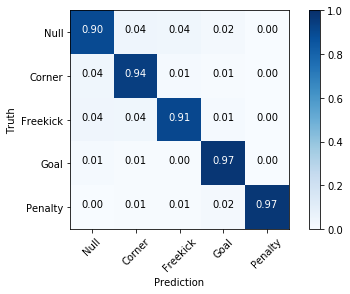

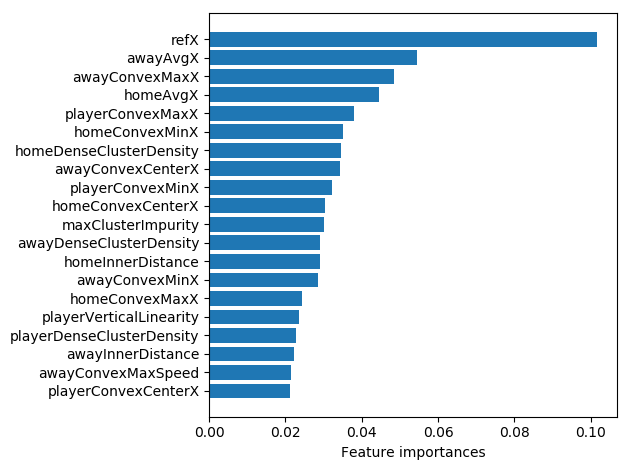

In [26]:
clf = RandomForestClassifier(
    n_estimators=128,
    criterion='gini',
    min_samples_split=10,
    max_features='sqrt',
    class_weight='balanced_subsample'
)
cm, fi = random_forest_cv(
    clf,
    x_train,
    y_train,
    feature_names,
    classes=classes,
    k=10
)

## Test Final Classifier on Held-Out Test Data
In this section, we test our previously trained and optimal classifier on separate test data.

In [6]:
test_data = pd.read_csv('../data/test/all_test.csv')
x_test = test_data.values[:, 1:]
y_test = test_data.values[:, 0]

# read the previously trained model
with open('../data/random_forest.pkl', 'rb') as f:
    clf = pickle.load(f)
clf

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [9]:
describe_dataset(test_data)

Shape: (61638, 45)

Event counts
------------
0	: 60007
60	: 439
62	: 290
80	: 712
93	: 190


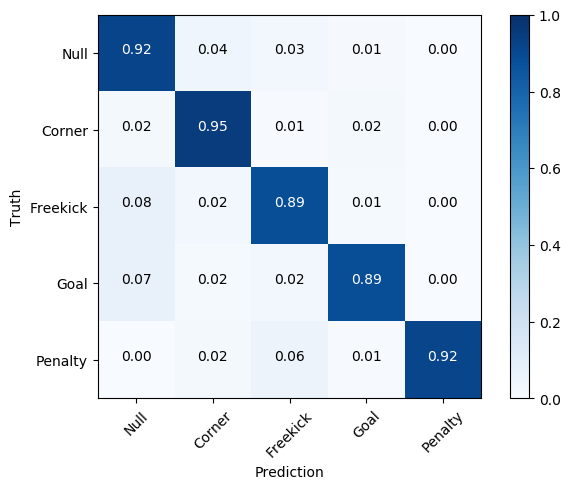

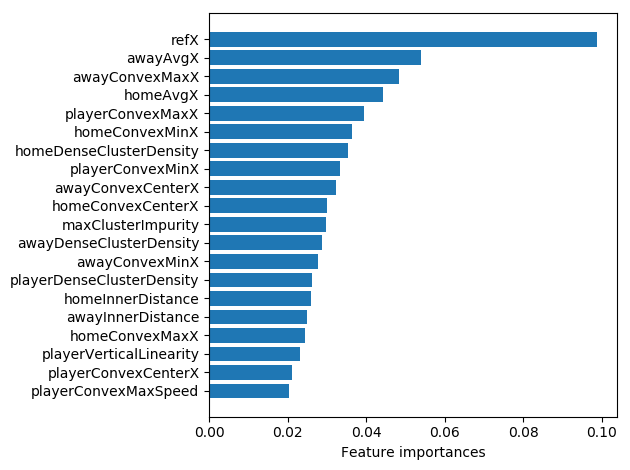

In [11]:
# predict
y_pred = clf.predict(x_test)

# compute the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# plot confusion matrix and feature importances
plot_confusion_matrix(conf_mat, classes, 'Prediction', 'Truth', normalize=True)
plot_hbar_nameval(feature_names, clf.feature_importances_, 'Feature importances', max_bars=20);